# Lab 3 lab notebook
We will revisit the oscilloscope and function generator. Using what we know from the 2nd lab, we will work with software to control both instruments remotely. This will allow for better documentation of measurements. It also provides a way to remove some of the tedium of a large measurement.

In [1]:
# This cell will import packages that we will need to run the scopes and collect and analyze data.

import pyvisa as visa  # This is python package that controls the usb communications
import numpy as np # This package will allow you to build arrays of data points 
import time # This is sometimes necessary to pause the code to allow a command to complete on one of the instruments.
import matplotlib.pyplot as plt # This allows you to plot data on graphs
from scale_scope import *

# Lab 03 Pre-Question
The work in this section must be completed and signed off by an instructor before you start working
on the lab. Do this work in your lab book.

## 3.2.1
Determine the frequencies that you should use to produce a Bode plot of the frequency responce for a system from 1Hz to 3 MHz if there will be 10 points per decade. Use the cell following this one to complete the calculation and display the results.

In [2]:
'''
    Question 1 calculations and displays
'''



'\n    Question 1 calculations and displays\n'

# 3.3.4
Frequency Responce of an R2R Ladder

In [3]:
# This cell will initialize the control of the usb ports and indentify any scopes or function generators that
# are attached.

rm = visa.ResourceManager('@py') #use pyvisa as the backend and define a resource manager
instruments = rm.list_resources() # get a list of instrument attached to the usb ports

# print out all of the instruments attached
print('A list of all instruments attached to the USB ports')
print(instruments)
print(' ')

# filter this list for Rigol scopes
Rigol_scopes = list(filter(lambda x: 'DS1' in x, instruments)) 

# filter this list for Rigol funtion generators
Rigol_funcgen = list(filter(lambda x: 'DG1' in x, instruments)) 

# print out the list of Rigol scopes
print('A list of the Rigol scopes attached to the USB ports')
print(Rigol_scopes)

# print out the list of Rigol funtion generators
print('A list of the Rigol function generators attached to the USB ports')
print(Rigol_funcgen)

A list of all instruments attached to the USB ports
('USB0::6833::1230::DS1ZC230300144::0::INSTR', 'USB0::6833::1602::DG1ZA224203424::0::INSTR')
 
A list of the Rigol scopes attached to the USB ports
['USB0::6833::1230::DS1ZC230300144::0::INSTR']
A list of the Rigol function generators attached to the USB ports
['USB0::6833::1602::DG1ZA224203424::0::INSTR']


In [4]:
'''
 This cell will initialize the scopes and function generators so that we can pass commands and 
 receive data back from them. Each instrument is initially set to its factory settings as a precaution. 
 We will later put in the specific settings that we want to use for our measurements. By starting from 
 the factory settings, we can be sure that there are no settings left over from a previous user.
'''
print("The number of scopes is: ", np.shape(Rigol_scopes)[0])
print("The number of fucntion generators is: ", np.shape(Rigol_funcgen)[0])

# Initialize the scope
for i in range(np.shape(Rigol_scopes)[0]):
    scope = rm.open_resource(Rigol_scopes[i], timeout=100000, chunk_size=1024000)
    scope.write(":*RST") # This is the command to set the instrument to factory default settings
    print("scope found")

# Initialize the fucntion generator
for i in range(np.shape(Rigol_funcgen)[0]):
    funcgen = rm.open_resource(Rigol_funcgen[i], timeout=100000, chunk_size=1024000)
    funcgen.write(":*RST") # This is the command to set the instrument to factory default settings
    print("function generator found")

# give each instrument some time to reset before you go in and start changing parameters
time.sleep(5) # Wait 5 seconds to continue

The number of scopes is:  1
The number of fucntion generators is:  1
scope found
function generator found


In [5]:
'''
 This cell will set the scope up to make the measurements that we are interested in. It will set the channel
 we are looking at as well as the timebase and scale of the channel.

 We need to use both channels 1 and 2. 
'''

# Channel 1 will be setup with the following:
scope.write(":CHAN1:DISP ON") # Turn on the display of channel 1
scope.write(":CHAN1:PROB 1") # Set the probe to a x1 probe
scope.write(":CHAN1:COUP DC") # set the couplong on channel 1 to DC
scope.write(":CHAN1:SCAL 0.2") # Set the scale to 0.2 V per division (square)

# Channel 2 will be setup with the following:
scope.write(":CHAN2:DISP ON") # Turn on the display of channel 2
scope.write(":CHAN2:PROB 1") # Set the probe to a x1 probe
scope.write(":CHAN2:COUP DC") # Set the coupling on channel 2 to DC
scope.write(":CHAN2:SCAL 2.0") # Set the scale to 2.0 V per division (square)
 
# Set the specifics for triggering a measurement
# The measurement will use the signal coming in on channel 2 to trigger the scope
scope.write(":TRIG:EDG:SOUR CHAN2") 
# A measurement is triggered when the signal hits 1.0 V
scope.write(":TRIG:EDG:LEV 1.0") 
# set the sweep to normal so the image is stable
scope.write(":TRIG:SWE NORM") 

# Set the horizontal scale for the measurement to 1 ms/division
scope.write(":TIM:MAIN:SCAL 0.001")

22

In [6]:
# This cell will set the parameters for the output signal produced by the function generator.

# Set the output level of channel 1 to 10 V peak-to-peak (Vpp)
funcgen.write(":SOUR1:VOLT 10") 

# Set the offset to +1.0 V
funcgen.write(":SOUR1:VOLT:OFFS 0.0") 

# Turn on the output of channel 1 (Don't forget this step or nothing will happen)
funcgen.write(":OUTP1 ON") 

# Set the frequency of the signal to 1500 Hz
funcgen.write(":SOUR1:FREQ 1.5E3") 

19

In [22]:
# This cell will make record measurements based on the signal produced by the fucntion generator.

# Set the scope to display the 3 different measurments, Vmax, Vmin, frequency on the screen. This
# does not record the measurement. It allows you to watch how things are going and possibly
# spot any issues that may be occuring.

# The peak-to-peak voltage on channel 1
scope.write(":MEAS:ITEM VPP,CHAN1")

# The peak-to-peak voltage on channel 2
scope.write(":MEAS:ITEM VPP,CHAN2")

# The difference in the time that the signal starts to rise between channel 2 
# and channel 1. rise time chan 2 - rise time chan 1.
# Why would this be important?
scope.write(":MEAS:ITEM RDEL,CHAN2,CHAN1")

# The next three lines set up arrays to hold values from each of the three measurements. 
# Array indexing in python starts at 0 and counts up from there. So a array with 10 elements 
# will start with [0] and go to [9]. We first need to figure out how many points we need.

n = 10 # The number of points to measure per decade
nd = 8 # Number of decades to measure
npts = n*nd+1 # The number of points that will be measured 

# Each of these will be an array zeros that is "npts" long
v1pp = np.zeros(npts) # peak-to-peak voltage channel 1 
v2pp = np.zeros(npts) # peak-to-peak voltage channel 2
rdel21 = np.zeros(npts) # the diference in the rise time between channels 2 and 1
f = np.zeros(npts) # the frequencies we will be using

# build the frequency array from 1 Hz to 3 MHz with 10 points per devade
f[0] = 1.0 # This is a temp value. The actual value will be set in the while loop
ii = 0 # This is the power of 10 for our initial decade.
while f[ii]<3.0e6:
    ii += 1
    f[ii]=10**(ii/n)
print(ii) # This is the actual number of data points to measure

# The next few lines will record the three measurements
for i in range(0,ii):
    scope.write(":RUN")
    
    # set the frequency on the function generator using our array of frequencies
    cmd = ":SOUR1:FREQ " + str(f[i])
    funcgen.write(cmd)
    
    # clear the scopes last measurement
    scope.write(":CLEAR")
    
    # set the horizontal scale on the scope to make good time measurements
    hscale_scope(scope,f[i]/2) #scale the horizontal axis
    
    # determine the value of the timebase used for this measurement
    tb = float(scope.query(":TIM:MAIN:SCAL?"))
    #tb = float(scope.read())
    #print(tb)
    
    # Sleep for the amount of time it takes to make one complete measurement across the 
    # screen. This will get smaller as the frequency gets larger.
    time.sleep(12*tb)

    # Set the vertical scales for channels 1 & 2 to make the best voltage measurements.
    vscale_scope(scope,"CHAN1",tb)
    vscale_scope(scope,"CHAN2",tb)
    
    # Sleep for the amount of time it takes to make one complete measurement across the 
    # screen. This will get smaller as the frequency gets larger.
    time.sleep(12*tb)

    # stop collecting data on the scope to record the measurements
    scope.write(":STOP")
    
    v2pp[i] = float(scope.query(":MEAS:ITEM? VPP,CHAN2"))
    v1pp[i] = float(scope.query(":MEAS:ITEM? VPP,CHAN1"))
    rdel21[i] = float(scope.query(":MEAS:ITEM? RDEL,CHAN2,CHAN1"))
    print("%i, %2.1e, %3.2f, %3.2f, %5.2e" %(i,f[i], v1pp[i],v2pp[i],rdel21[i]))


65
0, 1.0e+00, 0.64, 10.08, 5.00e-03
1, 1.3e+00, 0.64, 10.08, -6.00e-03
2, 1.6e+00, 0.64, 10.08, 2.00e-03
3, 2.0e+00, 0.64, 10.08, 2.00e-03
4, 2.5e+00, 0.64, 10.08, 1.00e-03
5, 3.2e+00, 0.64, 10.08, 1.00e-03
6, 4.0e+00, 0.64, 10.08, 1.00e-03
7, 5.0e+00, 0.64, 10.16, 5.00e-04
8, 6.3e+00, 0.64, 10.08, -1.50e-03
9, 7.9e+00, 0.64, 10.16, 5.00e-04
10, 1.0e+01, 0.64, 10.08, -6.00e-04
11, 1.3e+01, 0.64, 10.08, -6.00e-04
12, 1.6e+01, 0.64, 10.08, 2.00e-04
13, 2.0e+01, 0.64, 10.08, 2.00e-04
14, 2.5e+01, 0.64, 10.16, 1.00e-04
15, 3.2e+01, 0.64, 10.16, 1.00e-04
16, 4.0e+01, 0.65, 10.16, 1.00e-04
17, 5.0e+01, 0.64, 10.16, 5.00e-05
18, 6.3e+01, 0.65, 10.24, 5.00e-05
19, 7.9e+01, 0.64, 10.24, 5.00e-05
20, 1.0e+02, 0.64, 10.24, 5.00e-05
21, 1.3e+02, 0.64, 10.16, 2.00e-05
22, 1.6e+02, 0.64, 10.16, 2.00e-05
23, 2.0e+02, 0.64, 10.16, 2.00e-05
24, 2.5e+02, 0.63, 10.16, 3.00e-05
25, 3.2e+02, 0.64, 10.16, 1.00e-05
26, 4.0e+02, 0.64, 10.16, 1.00e-05
27, 5.0e+02, 0.64, 10.32, 5.00e-06
28, 6.3e+02, 0.64, 10.3

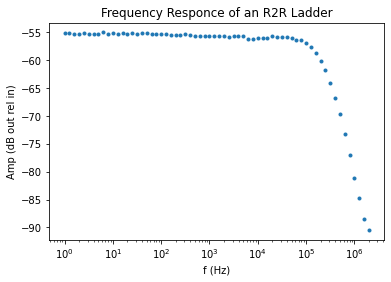

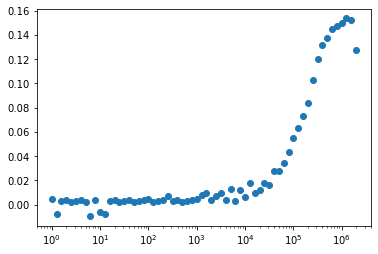

In [23]:
# Use this cell to plot the data that was collected in the last cell.

# Note that for a decibel measurement, you have to have some reference to measure against. 
# In this lab we are using the output signal at 1 kHz (make sure you know what element that
# is in the channel 1 data array). In other labs we might be looking at the output signal
# vs the input signal. You will need to adjust the next line of code accordingly.
dBs = 20*np.log(v1pp[0:ii-1]/v2pp[0:ii-1])

# Create a plot of the dB amplitudes in a semilog format
plt.semilogx(f[0:ii-1],dBs[0:ii-1],'.')

# label the x-axis
plt.xlabel("f (Hz)")

# label the y-axis
plt.ylabel("Amp (dB out rel in)")

# plot title
plt.title("Frequency Responce of an R2R Ladder")

# display the plot now
plt.show()

# Complete a plot of the phase difference in degrees between the input and output 
# signals. Be sure to include all of the appropriate labels.

phs21rising = rdel21*f
plt.semilogx(f[0:ii-1],phs21rising[0:ii-1],'o')
plt.show()

In [24]:
# Run this cell to make sure to close down the connection with the USB ports correctly. 
# If this cell is not run. Communications may be disrupted.
funcgen.close()
scope.close()
print('Ended program ready to run again')


Ended program ready to run again
